# Import packages and define utility functions

In [1]:
from __future__ import division, print_function, absolute_import
%matplotlib inline
%load_ext autoreload
%autoreload 2

import hepran
import hepran.bzipscore as bs
from hepran.draw_matrix import plot_matrix_mpl
import hepran.utils as u
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from set_utils import *


from scipy.stats import median_abs_deviation

In [25]:

def set_on_target(df, ids = "O1 O2 O3 O4 O5 O6 O7 O8 O9 O10 O11 O12 O13 O14 O15 O16".split()):
    df['on_target'] = False
    pairs = list(u.chunks(ids,2))
    for pair in pairs:
        df.loc[(pair[0], pair[1]), 'on_target'] = True
        df.loc[(pair[1], pair[0]), 'on_target'] = True
    return df

import re
ids = "O1 O2 O3 O4 O5 O6 O7 O8 O9 O10 O11 O12 O13 O14 O15 O16".split()
def natural_sorted(lst): 
    # Create a regular expression pattern to match numbers in the strings
    pattern = re.compile(r'(\d+)')
    
    # make shallow copy
    lst = list(lst)
    # Use the pattern to sort the list in natural order
    lst.sort(key=lambda s: [int(x) if x.isdigit() else x for x in pattern.split(s)])
    
    return lst

#natural_sorted(('S10', 'S2', 'banana', 'S12-4444'))
#natural_sorted(['S10', 'S2', 'banana'])
#natural_sorted(['S10', 'S2', 'banana', 'S12-4444'])

def get_mat(df,  field='score', title='', ids = "O1 O2 O3 O4 O5 O6 O7 O8 O9 O10 O11 O12 O13 O14 O15 O16".split()):   
    pairs = list(u.chunks(ids,2))
    ar = series_to_array(df[field], ids=ids, symetric=False)   
    return ar

def plot_df(df,  field='score', title='', ids = "O1 O2 O3 O4 O5 O6 O7 O8 O9 O10 O11 O12 O13 O14 O15 O16".split()):
    
    pairs = list(u.chunks(ids,2))
    ar = series_to_array(df[field], ids=ids, symetric=False)

    OI = bs.get_ortogonality_index(ar, aids=ids, pairs=pairs)
    GAP = bs.get_ortogonality_gap(ar, lower_is_better=False, aids=ids, pairs=pairs, kind='minmax')
    NAM = bs.get_num_offtarget_above(ar, lower_is_better=False, aids=ids, pairs=pairs, kind='min')
            
            
    atitle="{} ({}),\n(OI={:2.0f}, GAP={:2.1f}, NAM={:d})".format(title, field, OI, GAP, NAM)
    
    ax = bs.plot_matrix_mpl(mat=ar, aids=ids, cmap='viridis', title=atitle)


# A Python3 program to find all symmetric
# pairs in a given array of pairs.
 
# Print all pairs that have
# a symmetric counterpart
# inspired by: https://www.geeksforgeeks.org/given-an-array-of-pairs-find-all-symmetric-pairs-in-it/
def find_sym_pairs(pairs):
    from collections import defaultdict
    result = []
    # Creates an empty hashMap hM
    hM = defaultdict(list)
 
    # Traverse through the given array
    for pair in pairs:
         
        # First and second elements
        # of current pair
        
        first = pair[0]
        sec = pair[1]
        
        # If found and value in hash matches with first element of this pair, we found symmetry
        if (sec in hM.keys() and first in hM[sec]):
            result.append(natural_sorted((first,sec)))
            
        else: # Else put sec element of this pair in hash
            hM[first].append(sec)
            

    return result

#test = (("O1","O2"), ("O2","O1"), ("O1","O1"), ("O1", "O3"), ("O3", "O1"), ("O2", "O3"), ("O3", "O2"))
#find_sym_pairs(test)


def get_sym_diff(df, field, extra_fields=['on_target']):
    """Finds all sym pairs and does a difference of the field and copes extra fields over to new dataset.
    Must have double index"""
    result = []
    pairs = find_sym_pairs(list(df.index))
    for pair in pairs:
        first = pair[0]
        sec = pair[1]
        row = dict()
        row['ID1'] = first
        row['ID2'] = sec
        row[field] = df.loc[(pair[0], pair[1]), field] - df.loc[(pair[1], pair[0]), field] 
        for ef in extra_fields:
            row[ef] = df.loc[(pair[0], pair[1]), ef] 
        result.append(row)
    result=pd.DataFrame(result)
    result.set_index(['ID1','ID2'], inplace=True)
    return(result)

def print_uncertainty(df, field):
    print("Standard deviation: ") 
    print(f"{np.std(df[field]):.3f} standard deviation")
    if 'on_target' in df.columns:
        print(f"{np.std(df.query('on_target')[field]):.3f} on-target standard deviation ")
        print(f"{np.std(df.query('not on_target')[field]):.3f} off-target standard deviation ")

    print("")
    print("Median absolute deviation: ") 

    
    print(f"{median_abs_deviation(df[field], scale='normal'):.3f} median absolute difference")
    if 'on_target' in df.columns:
        print(f"{median_abs_deviation(df.query('on_target')[field], scale='normal'):.3f} on-target median absolute difference")
        print(f"{median_abs_deviation(df.query('not on_target')[field], scale='normal'):.3f} off-target median absolute difference")

def print_uncertainty_list(alist):
    print("Standard deviation: ") 
    print(f"{np.std(alist):.3f} standard deviation ")
 
    print("Median absolute deviation: ") 
    print(f"{median_abs_deviation(alist, scale='normal'):.3f} median absolute difference")
    

In [26]:
cc = pd.read_csv("data\CC0_1_and_2_raw.csv", sep=';')
cc.rename(columns={"X_peptide": "ID1", "Y_peptide": "ID2"}, inplace=True)

cc.set_index('ID1 ID2'.split(), inplace=True, drop=True)

# take the logarithm of the ratio
for col in 'RD1_x	RD2_x	medRD_mas1		RD1_y	RD2_y	medRD_mas2	'.split():
    cc[col]=np.log(cc[col])
display(cc)

RD1_x     RD2_x  medRD_mas1  bcnum_x     RD1_y     RD2_y  \
ID1 ID2                                                                
O1  O1  -2.929386 -2.674149   -2.832773      182 -2.588217 -2.745571   
    O10 -2.274934 -2.277267   -2.272448      149 -1.767662 -1.945910   
    O11 -2.840965 -2.659414   -2.743343      198 -2.583998 -2.595255   
    O12 -2.929711 -2.760418   -2.772589      197 -2.680600 -2.699674   
    O13 -2.731115 -2.587446   -2.633429      175 -2.302585 -2.359623   
...           ...       ...         ...      ...       ...       ...   
O9  O5  -3.025361 -2.786168   -2.926359      193 -2.548622 -2.602690   
    O6  -2.726069 -2.626048   -2.677148      198 -2.406374 -2.445068   
    O7  -3.129264 -2.872151   -2.936309      181 -2.632452 -2.728735   
    O8  -2.814740 -2.636497   -2.750265      168 -2.472484 -2.534720   
    O9  -2.863880 -2.785893   -2.843852      243 -2.632973 -2.582714   

         medRD_mas2  bcnum_y  
ID1 ID2                       
O1  O1    -2.647329       88  
    O10   -1.841850       99  
    O11   -2.568362      115  
    O12   -2.693209       96  
    O13   -2.362970       93  
...             ...      ...  
O9  O5    -2.547427      113  
    O6    -2.448435      116  
    O7    -2.687037      110  
    O8    -2.484907       91  
    O9    -2.600135      116  

[256 rows x 8 columns]

# Plot CC0 sets

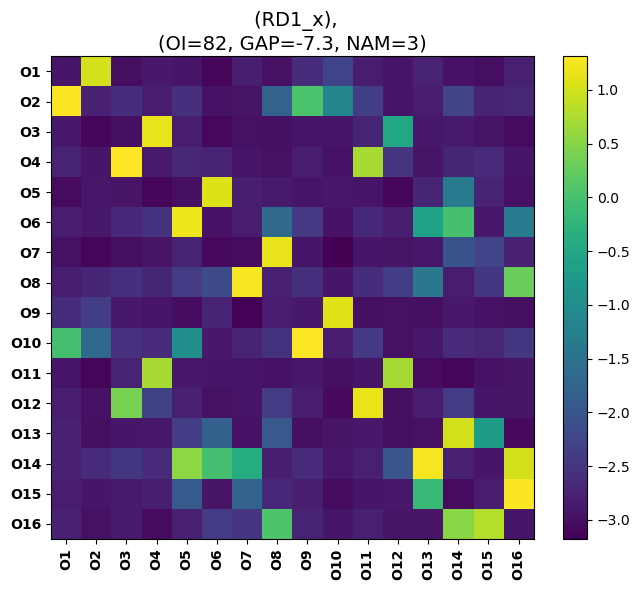

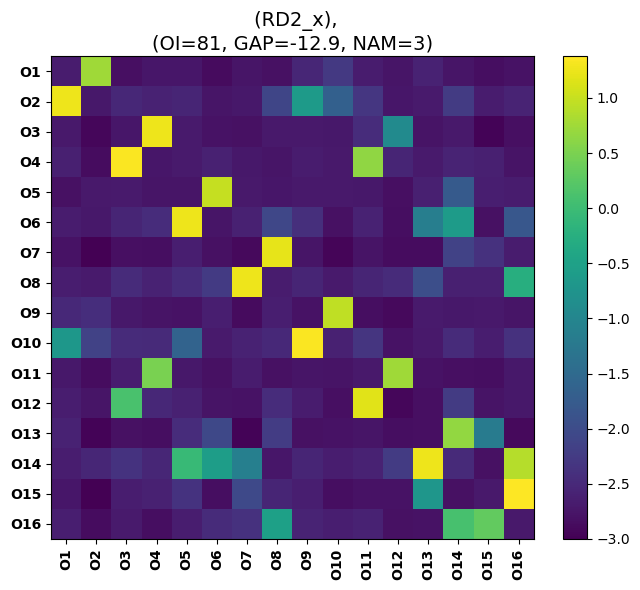

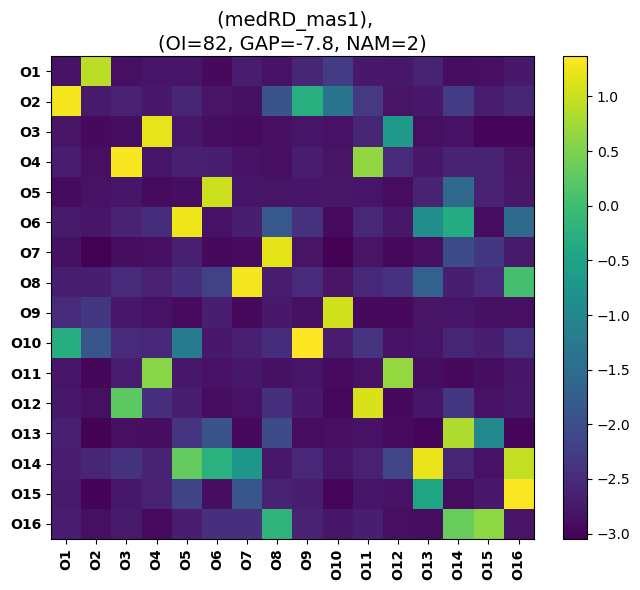

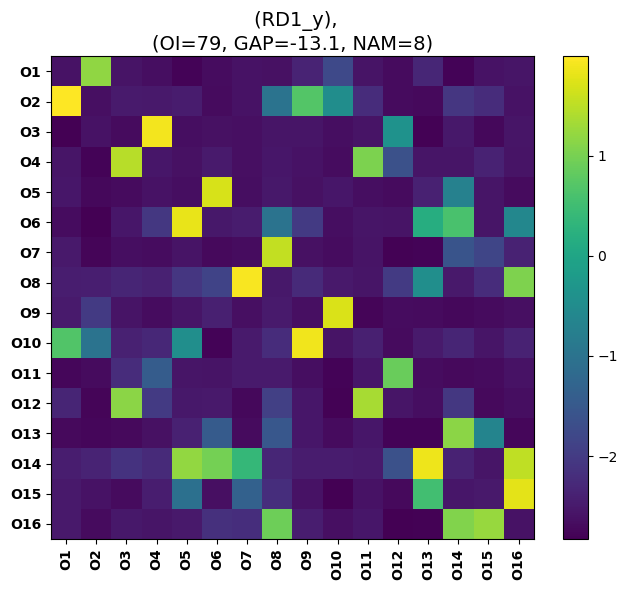

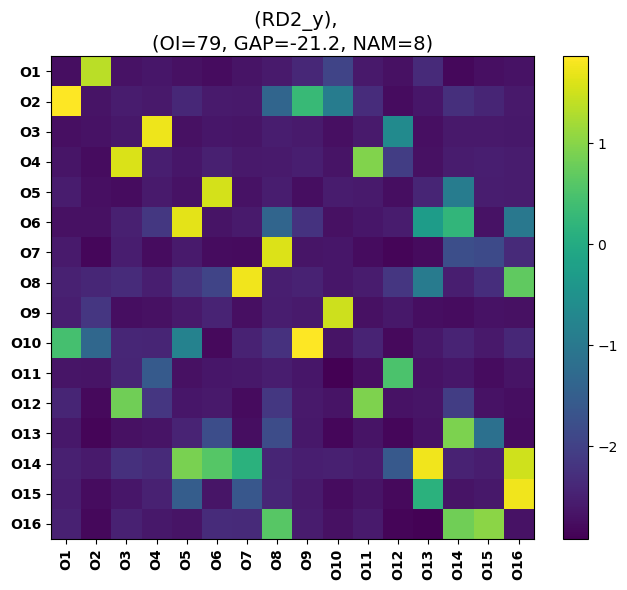

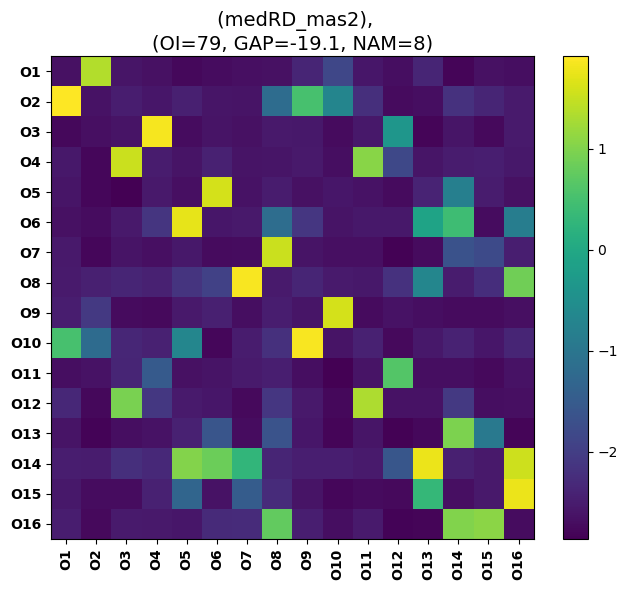

In [27]:
plot_df(cc, 'RD1_x')
plot_df(cc, 'RD2_x')
plot_df(cc, 'medRD_mas1')
plot_df(cc, 'RD1_y')
plot_df(cc, 'RD2_y')
plot_df(cc, 'medRD_mas2')

# Get difference between technical repeats 

Standard deviation: 
0.253 standard deviation
0.189 on-target standard deviation 
0.253 off-target standard deviation 

Median absolute deviation: 
0.137 median absolute difference
0.162 on-target median absolute difference
0.130 off-target median absolute difference


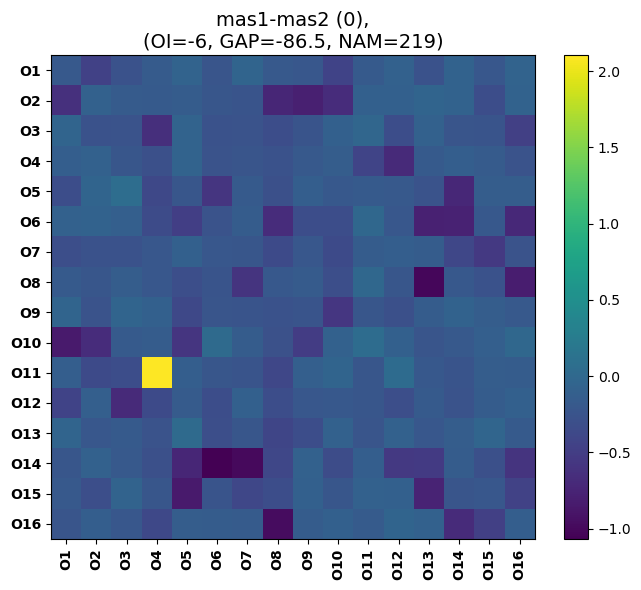

In [28]:

#Table S9 B
cc=set_on_target(cc)
gaps = cc.medRD_mas1-cc.medRD_mas2
gaps = gaps.to_frame()
gaps['on_target'] = cc.on_target
plot_df(gaps,0,'mas1-mas2')
print_uncertainty(gaps, 0)


Standard deviation: 
0.221 standard deviation
0.166 on-target standard deviation 
0.222 off-target standard deviation 

Median absolute deviation: 
0.110 median absolute difference
0.078 on-target median absolute difference
0.095 off-target median absolute difference


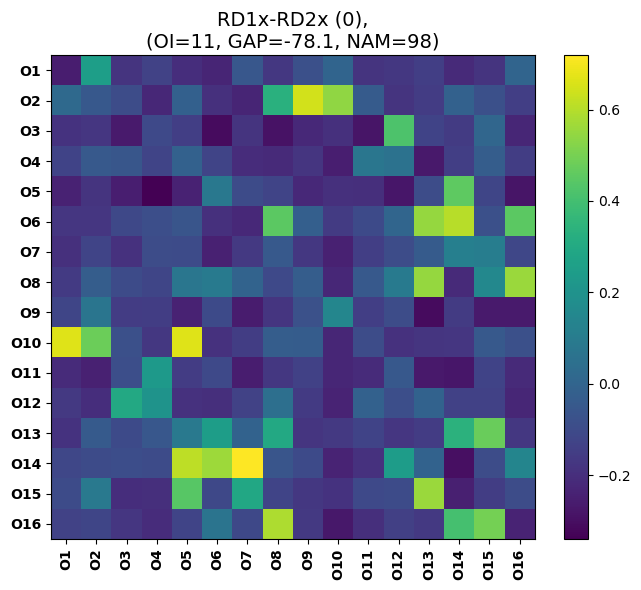

In [29]:
# just the normal difference between these two (no normalization)
cc=set_on_target(cc)
gaps = cc.RD1_x-cc.RD2_x
gaps = gaps.to_frame()
gaps['on_target'] = cc.on_target
plot_df(gaps,0,'RD1x-RD2x')
print_uncertainty(gaps, 0)

Standard deviation: 
0.126 standard deviation
0.157 on-target standard deviation 
0.123 off-target standard deviation 

Median absolute deviation: 
0.095 median absolute difference
0.103 on-target median absolute difference
0.091 off-target median absolute difference


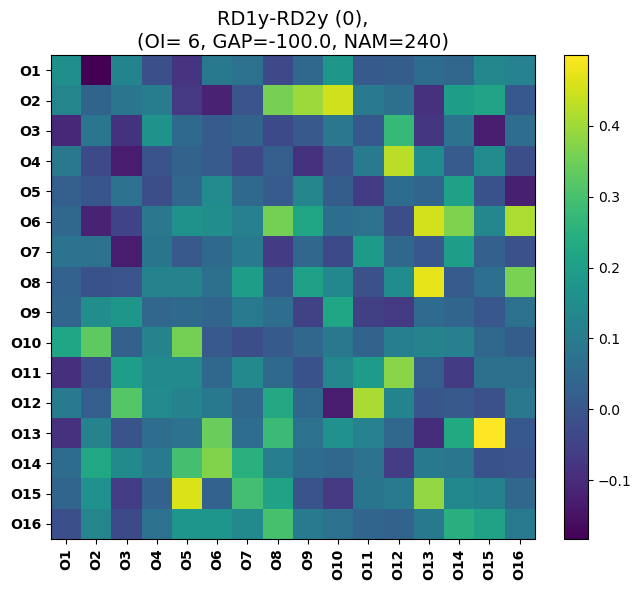

In [30]:
# just the normal difference between these two (no normalization)
cc=set_on_target(cc)
gaps = cc.RD1_y-cc.RD2_y
gaps = gaps.to_frame()
gaps['on_target'] = cc.on_target
plot_df(gaps,0,'RD1y-RD2y')
print_uncertainty(gaps, 0)

Standard deviation: 
0.465 standard deviation
0.356 on-target standard deviation 
0.471 off-target standard deviation 

Median absolute deviation: 
0.277 median absolute difference
0.210 on-target median absolute difference
0.271 off-target median absolute difference


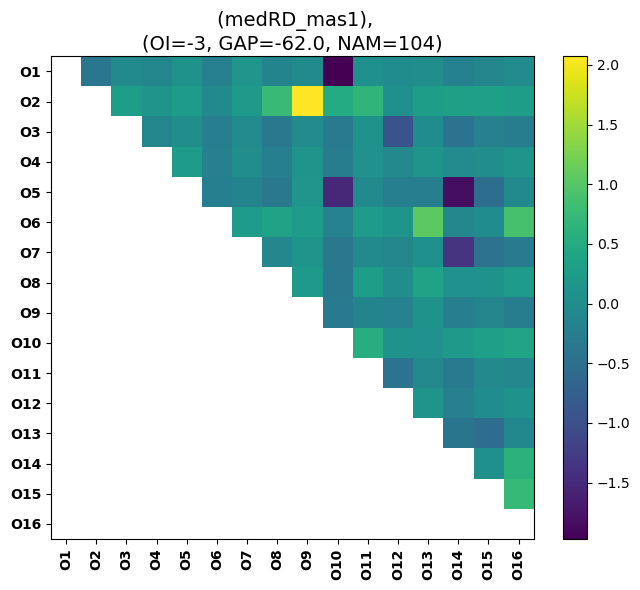

In [31]:
# Table S9 C
field = 'medRD_mas1'
sym_diff=get_sym_diff(cc, field, ['on_target'])
plot_df(sym_diff, field=field, ids=ids)
print_uncertainty(sym_diff, field=field)

Standard deviation: 
0.637 standard deviation
0.477 on-target standard deviation 
0.645 off-target standard deviation 

Median absolute deviation: 
0.251 median absolute difference
0.482 on-target median absolute difference
0.237 off-target median absolute difference


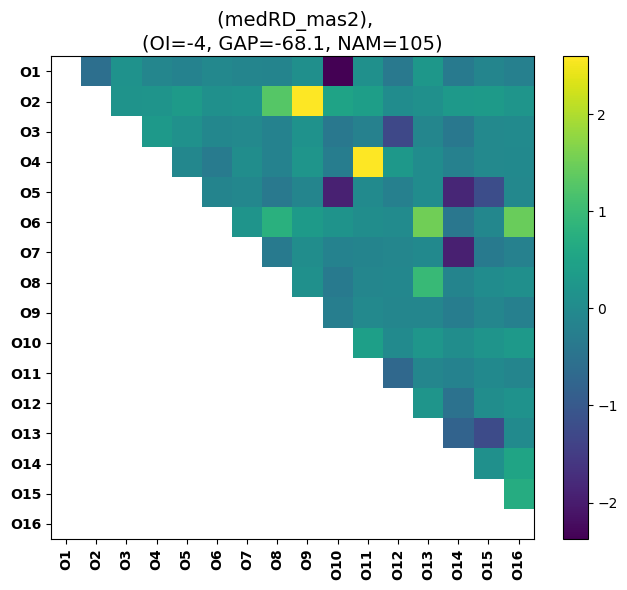

In [32]:
# Table S9 D
field = 'medRD_mas2'
sym_diff=get_sym_diff(cc, field, ['on_target'])
plot_df(sym_diff, field=field, ids=ids)
print_uncertainty(sym_diff, field=field)

Standard deviation: 
0.365 standard deviation
0.272 on-target standard deviation 
0.364 off-target standard deviation 

Median absolute deviation: 
0.197 median absolute difference
0.234 on-target median absolute difference
0.187 off-target median absolute difference


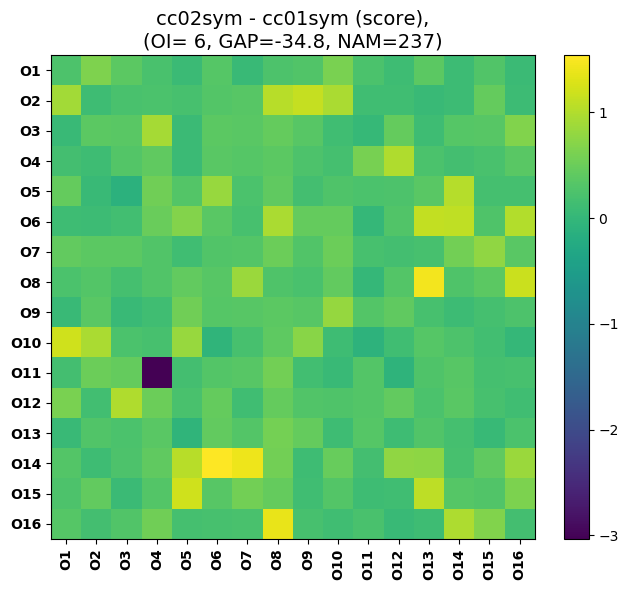

In [33]:
#Table S9 row A)
# Difference of symmetrized repeats 
cc01 = pd.read_csv("data/cc01.tsv", sep='\t')
cc01.set_index('ID1	ID2'.split(), inplace=True, drop=False)
cc01.score = np.log2(cc01.score)
set_on_target(cc01)  

cc02 = pd.read_csv("data/cc02.tsv", sep='\t')
cc02.set_index('ID1	ID2'.split(), inplace=True, drop=False)
cc02.score = np.log2(cc02.score)
set_on_target(cc02)  

diff = cc01.copy()
diff.score = cc02.score-cc01.score
plot_df(diff, 'score','cc02sym - cc01sym')
print_uncertainty(diff, field='score')

In [16]:
## Test the R8000 -- CCNG1
## CCNG1 does not have the switched enzymes pairs due to a mistake.
#ccng1 = pd.read_csv("data/sumR8000.csv.gz", index_col=0)
#ccng1.rename(columns = {'X_peptide':'ID1', 'Y_peptide':'ID2','X_group':'bcf_set'}, inplace = True)
#ccng1.bcf_set = ccng1.bcf_set.fillna('')
## take only condition 6
#ccng1 = ccng1.query('condition==6')
## join IDs to bcf set
#ccng1.ID1 = ccng1.ID1+ccng1.bcf_set  
#ccng1.ID2 = ccng1.ID2+ccng1.bcf_set
#ccng1.set_index(['ID1', 'ID2'], inplace=True, drop=False)
#cc0__ccng1 =ccng1.query(f'ID1 in @ids and  ID2 in @ids')
#cc0__ccng1.med_RD =  np.log(cc0__ccng1.med_RD)

c:\bin\python\anaconda64\envs\ortoCC\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [34]:
ccmax = pd.read_csv("data/sumR18k-unzip.csv.gz", index_col=None)
ccmax.columns
#ccmax.rename(columns = {'X_peptide':'ID1', 'Y_peptide':'ID2'}, inplace = True)
#ccmax.set_index(['ID1', 'ID2'], inplace=True, drop=False)
ccmax['ln_medRDboth']=np.log(ccmax.query('medRDboth > 0')['medRDboth'])

aaids = [anid+"-AA" for anid in ids]
cc0__ccmax =ccmax.query(f'ID1 in @aaids and  ID2 in @aaids')
cc0__ccmax.set_index(['ID1', 'ID2'], inplace=True, drop=False)
cc0__ccmax



X_peptide X_group Y_peptide Y_group  medRDboth  bcnum     ID1  \
ID1    ID2                                                                    
O15-AA O1-AA      4H171     -AA        O1     -AA   0.221698     10  O15-AA   
       O11-AA     4H171     -AA       O11     -AA   0.260116      3  O15-AA   
       O13-AA     4H171     -AA       O13     -AA  11.888889     25  O15-AA   
       O14-AA     4H171     -AA       O14     -AA   0.337407     16  O15-AA   
       O2-AA      4H171     -AA        O2     -AA   0.254808      2  O15-AA   
...                 ...     ...       ...     ...        ...    ...     ...   
O9-AA  O15-AA        P9     -AA     4H171     -AA   0.402023      8   O9-AA   
       O16-AA        P9     -AA    4H3016     -AA   0.392628      4   O9-AA   
       O12-AA        P9     -AA     4H384     -AA   0.421053      2   O9-AA   
       O10-AA        P9     -AA       P10     -AA   8.516387     26   O9-AA   
       O9-AA         P9     -AA        P9     -AA   0.139785      5   O9-AA   

                  ID2  ln_medRDboth  
ID1    ID2                           
O15-AA O1-AA    O1-AA     -1.506439  
       O11-AA  O11-AA     -1.346629  
       O13-AA  O13-AA      2.475604  
       O14-AA  O14-AA     -1.086464  
       O2-AA    O2-AA     -1.367246  
...               ...           ...  
O9-AA  O15-AA  O15-AA     -0.911247  
       O16-AA  O16-AA     -0.934892  
       O12-AA  O12-AA     -0.864997  
       O10-AA  O10-AA      2.141992  
       O9-AA    O9-AA     -1.967650  

[254 rows x 9 columns]

c:\bin\python\anaconda64\envs\ortoCC\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\bin\python\anaconda64\envs\ortoCC\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Standard deviation: 
0.777 standard deviation
0.556 on-target standard deviation 
0.790 off-target standard deviation 

Median absolute deviation: 
0.711 median absolute difference
0.457 on-target median absolute difference
0.762 off-target median absolute difference


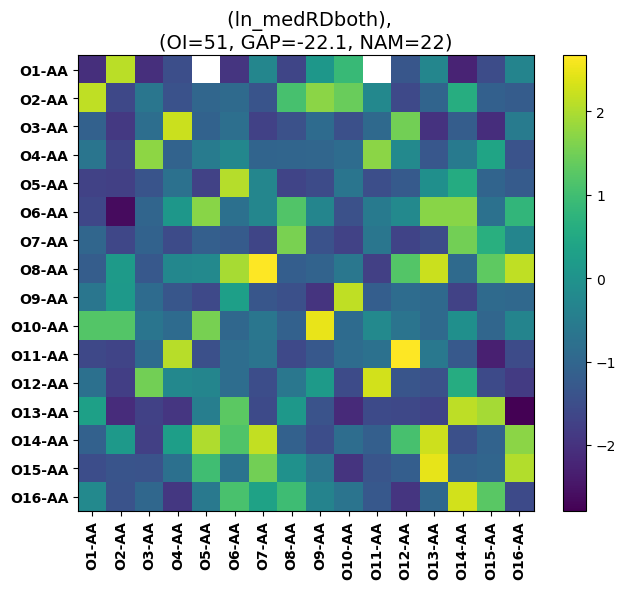

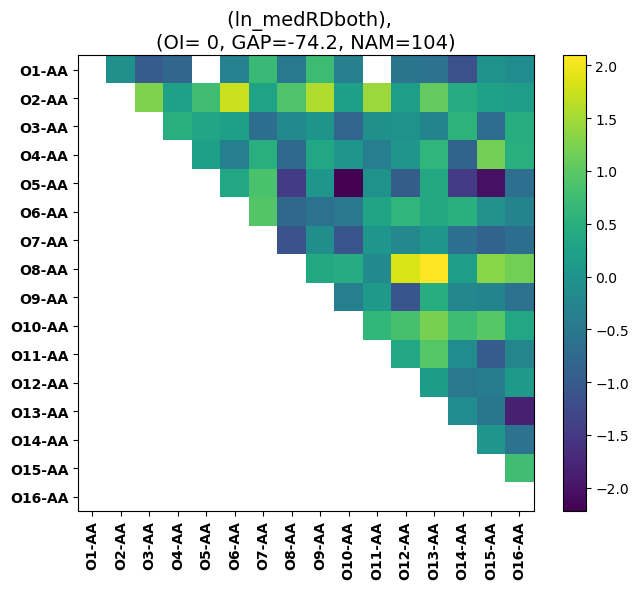

In [35]:
field='ln_medRDboth'
plot_df(cc0__ccmax, field, ids=aaids )
cc0__ccmax['on_target'] = False
set_on_target(cc0__ccmax, ids=aaids )
sym_diff=get_sym_diff(cc0__ccmax, field, ['on_target'])
plot_df(sym_diff, field=field, ids=aaids)
print_uncertainty(sym_diff, field=field)

In [36]:
field='ln_medRDboth'
ccmax.dropna(inplace=True)
ccmax.set_index(['ID1', 'ID2'], inplace=True, drop=False)
sym_diff=get_sym_diff(ccmax, field, [])
print_uncertainty(sym_diff, field)


Standard deviation: 
0.839 standard deviation

Median absolute deviation: 
0.736 median absolute difference
